<a href="https://colab.research.google.com/github/Explorer2024-jims/Explore/blob/main/EmailAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import mailbox
import pandas as pd
from email import policy
from email.parser import BytesParser
import os
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser



In [7]:
# Download NLTK VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to extract email body text based on its type (plain text or HTML)
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))
            if content_type == "text/plain" and "attachment" not in content_disposition:
                return part.get_payload(decode=True).decode(errors="replace")
            elif content_type == "text/html" and "attachment" not in content_disposition:
                return part.get_payload(decode=True).decode(errors="replace")
    else:
        return msg.get_payload(decode=True).decode(errors="replace")
    return ""

# Function to extract attachments
def extract_attachments(msg, output_dir="attachments"):
    attachments = []
    if msg.is_multipart():
        for part in msg.walk():
            content_disposition = str(part.get("Content-Disposition"))
            if "attachment" in content_disposition:
                filename = part.get_filename()
                if filename:
                    attachment_data = part.get_payload(decode=True)
                    filepath = os.path.join(output_dir, filename)
                    with open(filepath, "wb") as f:
                        f.write(attachment_data)
                    attachments.append(filepath)
    return attachments

# Custom function to handle parsing dates, including timezone offsets
def parse_date(date_str):
    try:
        return parser.parse(date_str)
    except (ValueError, TypeError):
        return pd.NaT

# Specify the path to your mbox file
mbox_path = '/content/All mail Including Spam and Trash.mbox'

# Open the mbox file
mbox = mailbox.mbox(mbox_path)

# Create an empty list to store email data
emails = []

# Ensure attachments directory exists
os.makedirs("attachments", exist_ok=True)

# Iterate through each message in the mbox file
for message in mbox:
    try:
        msg = BytesParser(policy=policy.default).parsebytes(message.as_bytes())
        # Extract email details
        email_data = {
            'From': msg['From'],
            'To': msg['To'],
            'Subject': msg['Subject'],
            'Date': msg['Date'],
            'Content-Type': msg.get_content_type(),
            'Body': extract_body(msg),
            'Attachments': extract_attachments(msg)
        }
        emails.append(email_data)
    except Exception as e:
        print(f"Error processing message: {e}")



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Convert the list of emails to a DataFrame
df = pd.DataFrame(emails)

# Apply the custom date parsing function
df['Date'] = df['Date'].apply(lambda x: parse_date(x) if isinstance(x, str) else pd.NaT)

# Drop rows with NaT values
df_clean = df.dropna(subset=['Date'])

# Ensure 'Date' column is datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')

# Apply sentiment analysis
df_clean['Sentiment'] = df_clean['Body'].apply(lambda x: sia.polarity_scores(x)['compound'] if pd.notna(x) else None)


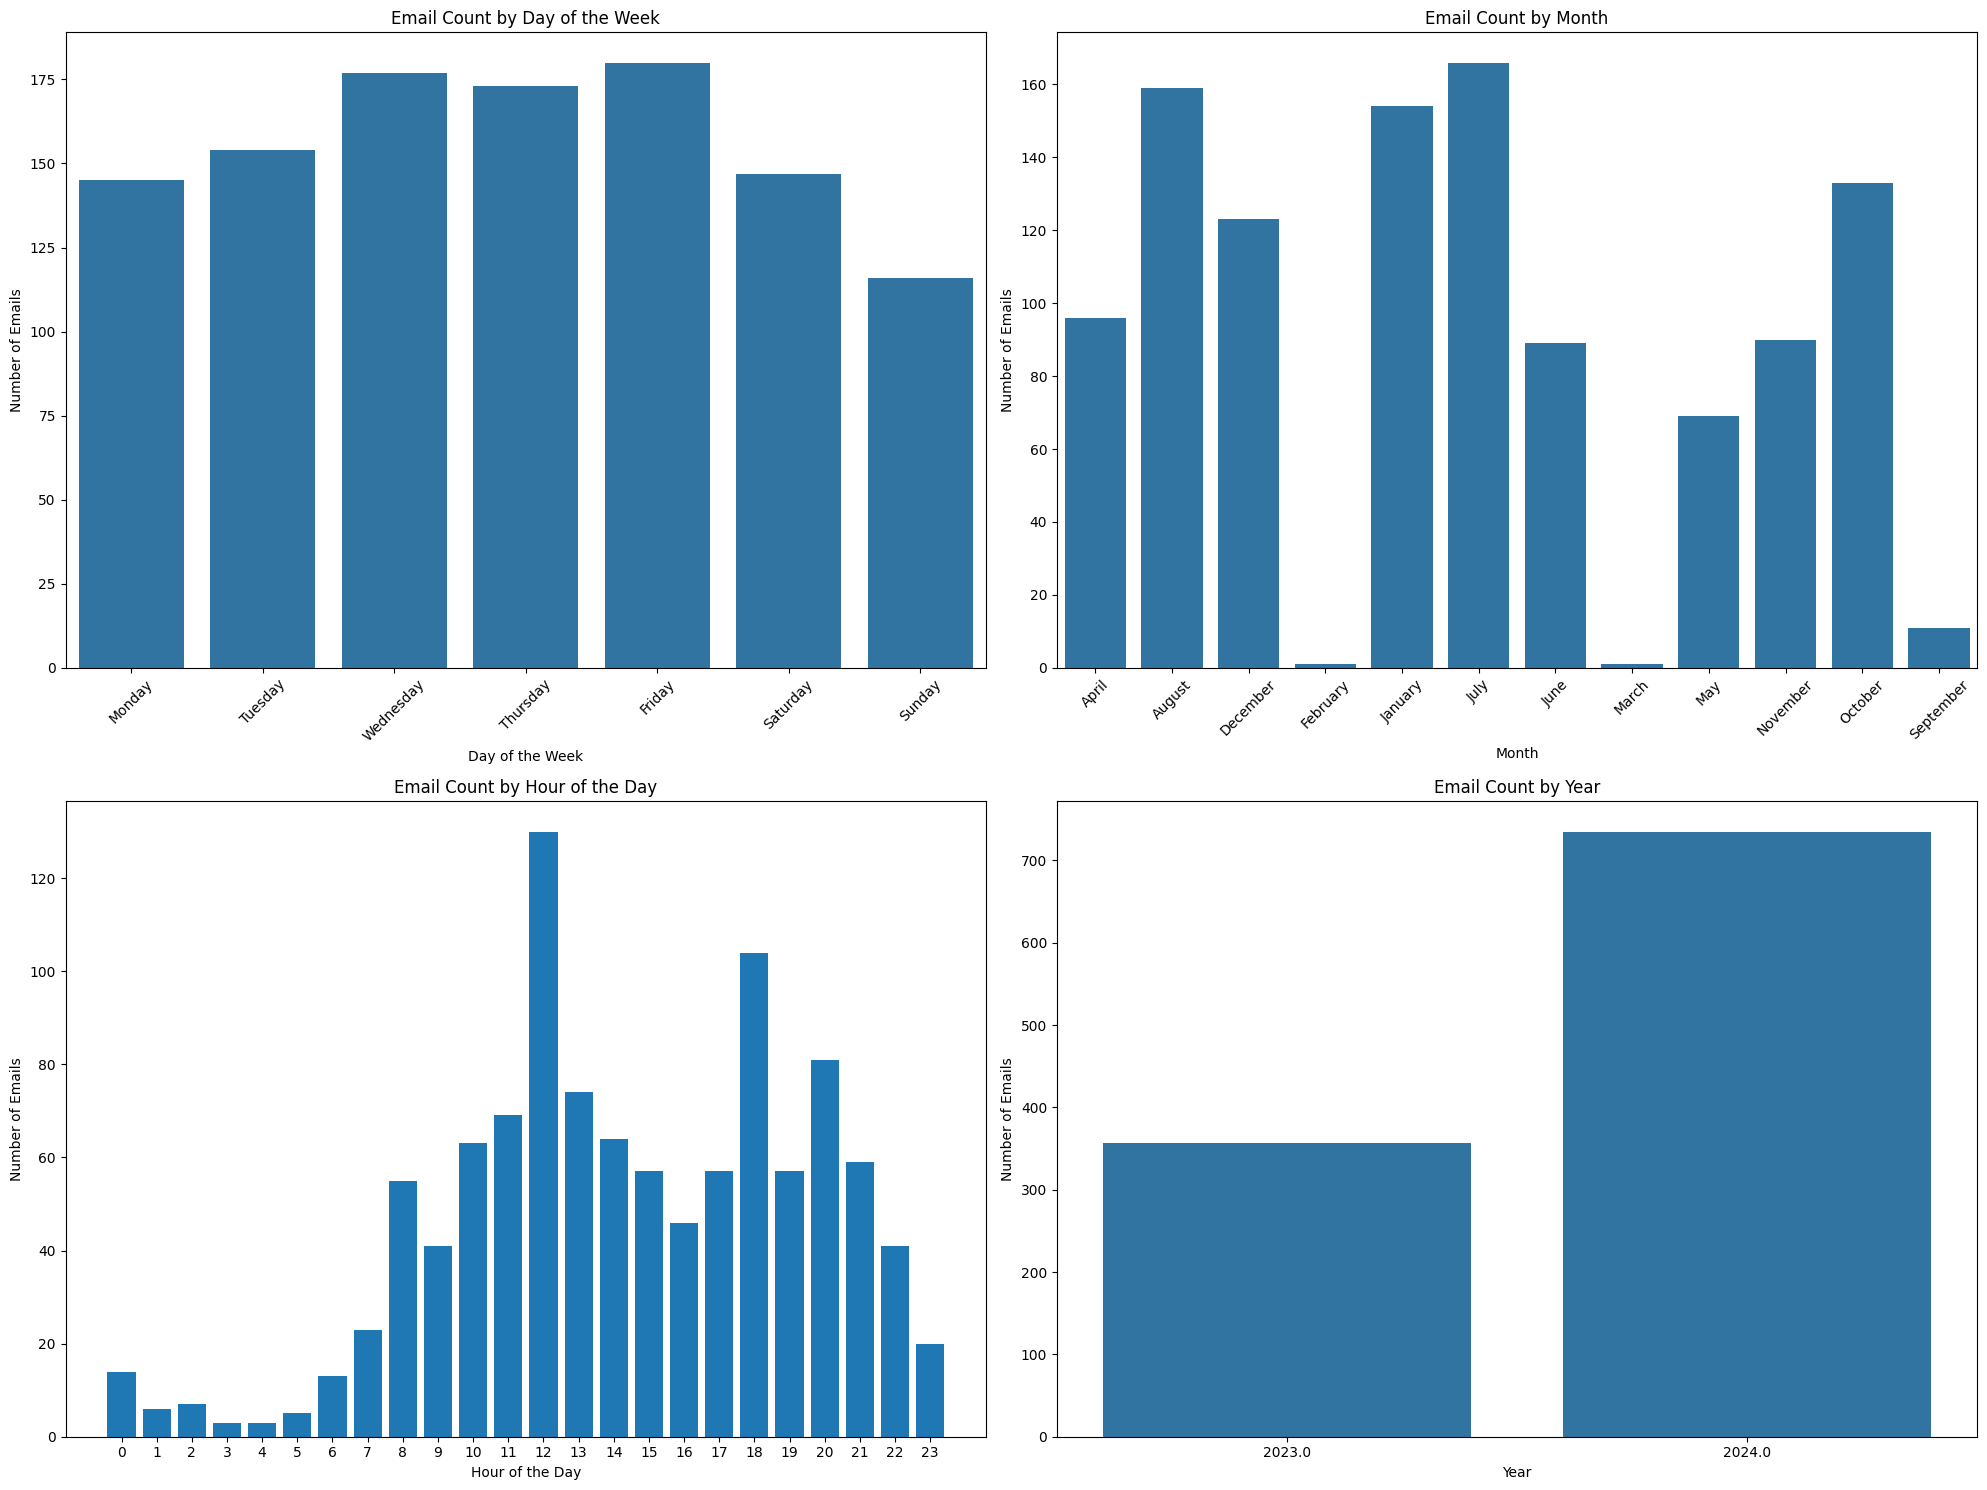

In [9]:
# Data visualization for count of emails

plt.figure(figsize=(20, 15))

# Email Count by Day of the Week
plt.subplot(2, 2, 1)
df_clean['DayOfWeek'] = df_clean['Date'].dt.day_name()
day_counts = df_clean['DayOfWeek'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Email Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45)

# Email Count by Month
plt.subplot(2, 2, 2)
df_clean['Month'] = df_clean['Date'].dt.month_name()
month_counts = df_clean['Month'].value_counts().reindex(pd.date_range(start='2024-01-01', end='2024-12-31', freq='M').month_name())
month_counts = month_counts.sort_index()  # Sort months in chronological order
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.title('Email Count by Month')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45)

# Email Count by Hour of the Day
plt.subplot(2, 2, 3)
hour_counts = df_clean['Date'].dt.hour.value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Email Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Emails')
plt.xticks(range(24))

# Email Count by Year
plt.subplot(2, 2, 4)
df_clean['Year'] = df_clean['Date'].dt.year
year_counts = df_clean['Year'].value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('Email Count by Year')
plt.xlabel('Year')
plt.ylabel('Number of Emails')

plt.tight_layout()
plt.show()


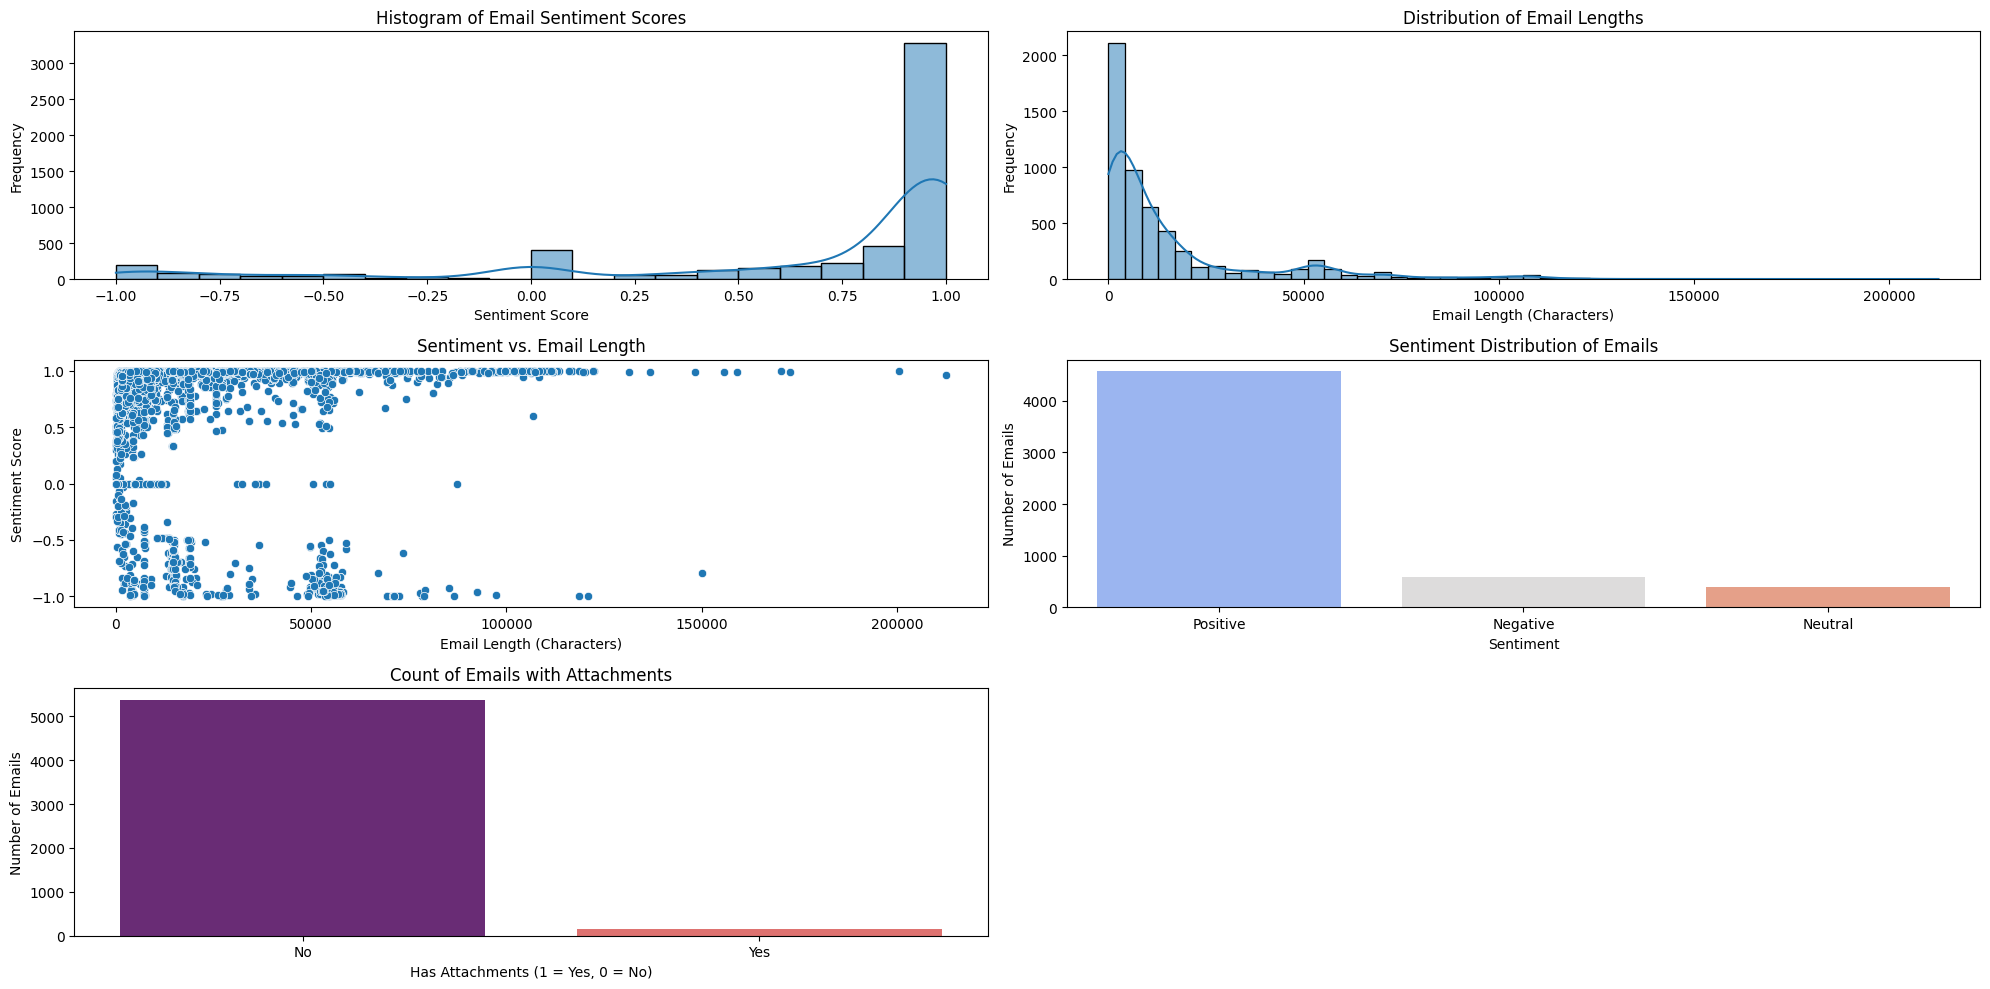

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Sentiment Distribution
plt.subplot(3, 2, 1)
sns.histplot(df_clean['Sentiment'], bins=20, kde=True)
plt.title('Histogram of Email Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Distribution of Email Lengths
plt.subplot(3, 2, 2)
df_clean['BodyLength'] = df_clean['Body'].apply(lambda x: len(x) if pd.notna(x) else 0)
sns.histplot(df_clean['BodyLength'], bins=50, kde=True)
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length (Characters)')
plt.ylabel('Frequency')

# Sentiment vs. Email Length
plt.subplot(3, 2, 3)
sns.scatterplot(x='BodyLength', y='Sentiment', data=df_clean)
plt.title('Sentiment vs. Email Length')
plt.xlabel('Email Length (Characters)')
plt.ylabel('Sentiment Score')

# Sentiment Distribution of Emails
plt.subplot(3, 2, 4)
df_clean['Sentiment'].fillna(0, inplace=True)  # Handle NaN values for plotting
df_clean['Sentiment'] = df_clean['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
sns.countplot(x='Sentiment', data=df_clean, palette='coolwarm', hue='Sentiment', dodge=False, legend=False)
plt.title('Sentiment Distribution of Emails')
plt.xlabel('Sentiment')
plt.ylabel('Number of Emails')

# Count of Emails with Attachments
plt.subplot(3, 2, 5)
df_clean['Has_Attachments'] = df_clean['Attachments'].apply(lambda x: 1 if x and len(x) > 0 else 0)
sns.countplot(x='Has_Attachments', data=df_clean, palette='magma', hue='Has_Attachments', dodge=False, legend=False)
plt.title('Count of Emails with Attachments')
plt.xlabel('Has Attachments (1 = Yes, 0 = No)')
plt.ylabel('Number of Emails')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.tight_layout()
plt.show()


Sent Emails Count: 100
Received Emails Count: 5417
Sent Emails with Attachments Count: 57


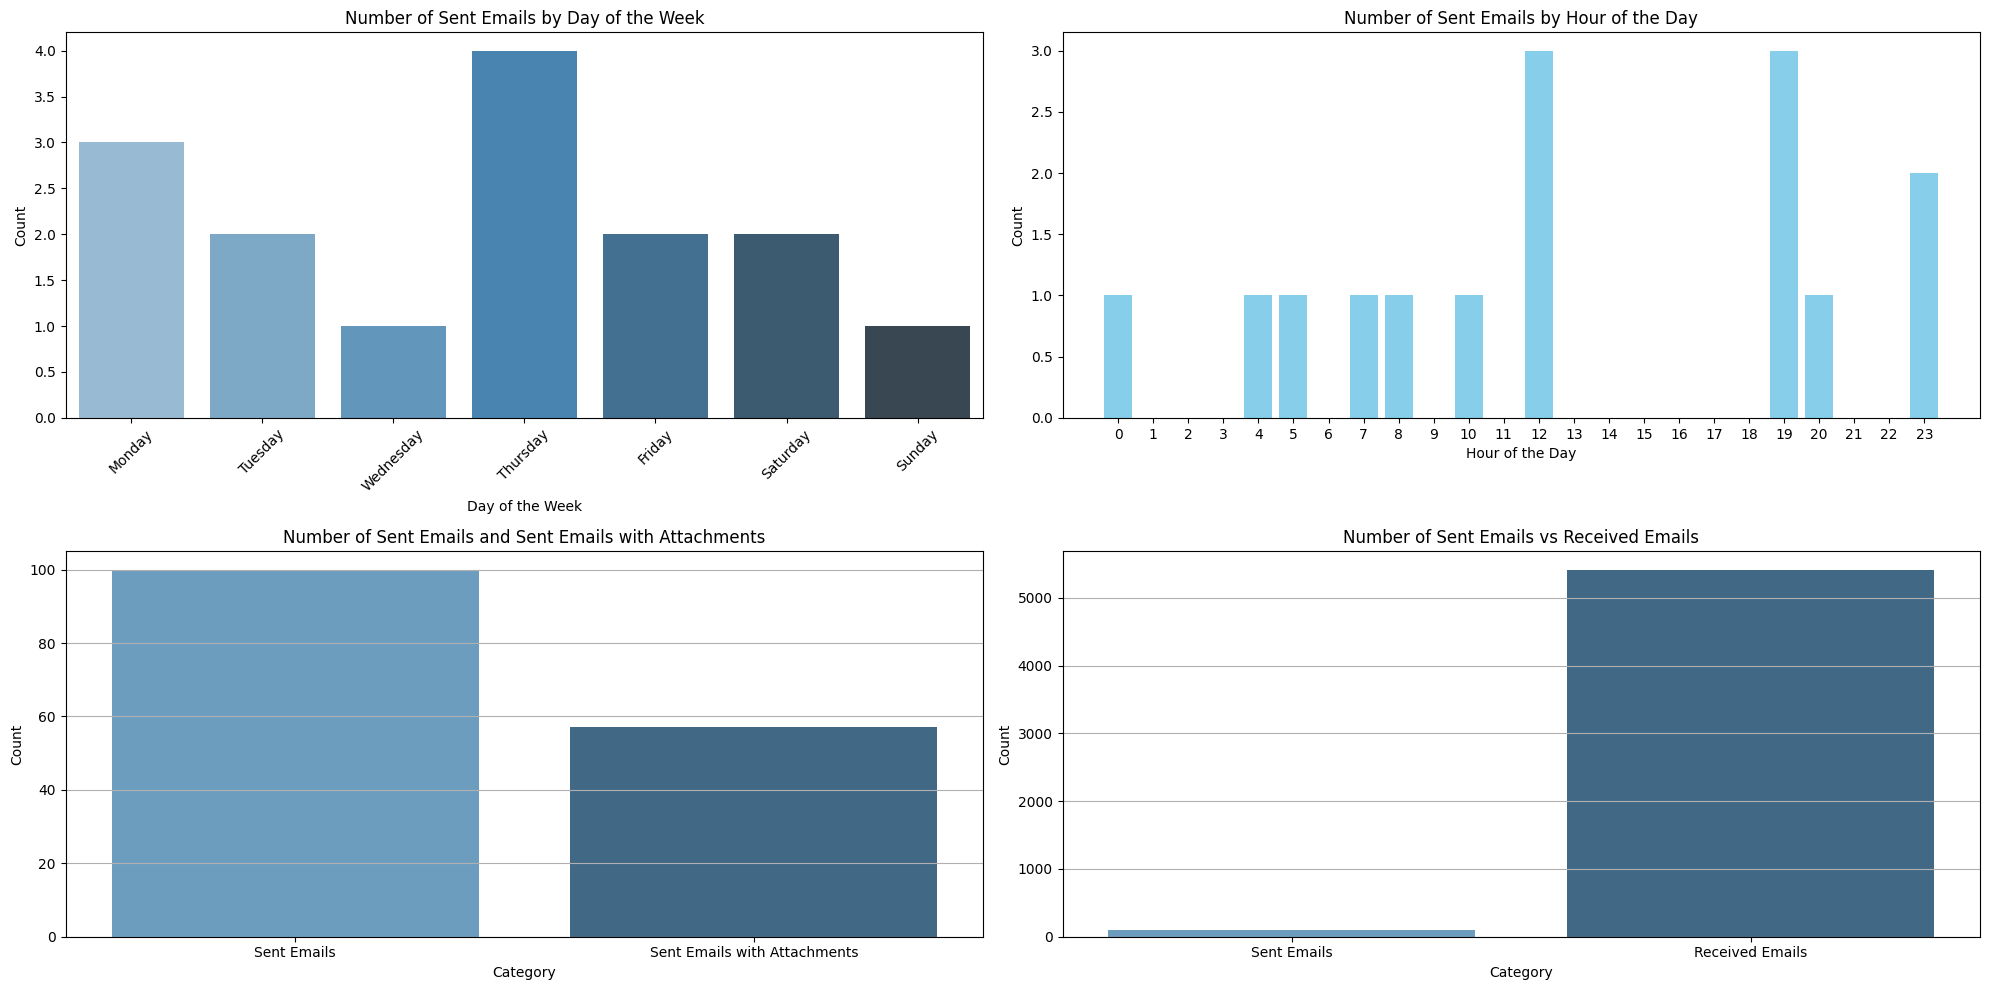

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for sent emails based on 'From' column containing "6974"
sent_emails = df_clean[df_clean['From'].str.contains("6974", na=False, case=False)].copy()

# Filter for received emails based on 'To' column containing "6974"
received_emails = df_clean[df_clean['To'].str.contains("6974", na=False, case=False)].copy()

# Count the number of sent emails
sent_emails_count = sent_emails.shape[0]

# Count the number of received emails
received_emails_count = received_emails.shape[0]

# Count the number of sent emails with attachments
sent_emails_with_attachments_count = sent_emails[
    sent_emails['Attachments'].notna() &
    sent_emails['Attachments'].apply(lambda x: len(x) > 0)
].shape[0]

print(f"Sent Emails Count: {sent_emails_count}")
print(f"Received Emails Count: {received_emails_count}")
print(f"Sent Emails with Attachments Count: {sent_emails_with_attachments_count}")

# Analyze sent emails by weekday
sent_emails['DayOfWeek'] = sent_emails['Date'].dt.day_name()
weekday_counts = sent_emails['DayOfWeek'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Analyze sent emails by hour
sent_emails['Hour'] = sent_emails['Date'].dt.hour
hour_counts = sent_emails['Hour'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(20, 10))

# Plot the count of sent emails by weekday
plt.subplot(2, 2, 1)
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, hue=weekday_counts.index, palette='Blues_d', legend=False)
plt.title('Number of Sent Emails by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot the count of sent emails by hour
plt.subplot(2, 2, 2)
plt.bar(hour_counts.index, hour_counts.values, color='skyblue')
plt.title('Number of Sent Emails by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(range(24))

# Plot the number of sent emails vs sent emails with attachments
plt.subplot(2, 2, 3)
data_attachments = {
    'Category': ['Sent Emails', 'Sent Emails with Attachments'],
    'Count': [sent_emails_count, sent_emails_with_attachments_count]
}
plot_df_attachments = pd.DataFrame(data_attachments)
sns.barplot(x='Category', y='Count', data=plot_df_attachments, hue='Category', palette='Blues_d', dodge=False, legend=False)
plt.title('Number of Sent Emails and Sent Emails with Attachments')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y')

# Plot the number of sent emails vs received emails
plt.subplot(2, 2, 4)
data_sent_received = {
    'Category': ['Sent Emails', 'Received Emails'],
    'Count': [sent_emails_count, received_emails_count]
}
plot_df_sent_received = pd.DataFrame(data_sent_received)
sns.barplot(x='Category', y='Count', data=plot_df_sent_received, hue='Category', palette='Blues_d', dodge=False, legend=False)
plt.title('Number of Sent Emails vs Received Emails')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y')

plt.tight_layout()
plt.show()
